In [1]:
import pandas as pd 
import numpy as np 
import re 
import altair as alt 
import matplotlib.pyplot as plt 
data = pd.read_csv('data/participant_data.csv')
data.Biomarker = [re.sub("Biomarker ", "", text) for text in data.Biomarker.tolist()]
data.head()
# but remember that we do not know k_j which is what we are trying to estimate. 

,Biomarker,participant,measurement,k_j,S_n,affected_or_not
0,0,0,10.336151,1,5,not_affected
1,0,1,10.865467,1,5,not_affected
2,0,2,1.238857,7,5,affected
3,0,3,10.163485,2,5,not_affected
4,0,4,11.036735,0,5,not_affected


In [2]:
data.S_n.unique()

array([ 5,  7,  6,  4,  8,  2,  9, 10,  1,  3])

In [3]:
data.k_j.unique()

array([ 1,  7,  2,  0,  3,  5, 10,  8,  4,  6,  9])

In [4]:
theta_phi = pd.read_csv('data/means_vars.csv')
theta_phi.head()

,biomarker,theta_mean,theta_var,phi_mean,phi_var
0,0,1.0,0.3,12.0,1.3
1,1,3.0,0.5,11.0,2.4
2,2,5.0,0.2,14.0,1.4
3,3,6.0,1.3,16.0,0.9
4,4,8.0,3.3,18.0,1.5


In [5]:
def compute_likelihood(theta_phi, biomarker, affected, measurement):
    '''Computes the likelihood of the given measurement data; note that measurement here
    is the value for a single biomarker
    We know the normal distribution defined by either theta or phi
    and we know the measurement. This will give us the probability
    of the given measurement. 

    input:
    - theta_phi: the dataframe containing theta and phi values for each biomarker
    - biomarker: an integer between 0 and 9 
    - affected: boolean 
    - measurement: the observed value for a biomarker in a specific participant

    output: a number 
    '''
    biomarker_params = theta_phi[theta_phi.biomarker == biomarker].reset_index()
    mu = biomarker_params['theta_mean'][0] if affected else biomarker_params['phi_mean'][0]
    var = biomarker_params['theta_var'][0] if affected else biomarker_params['phi_var'][0]
    sigma = np.sqrt(var)
    return np.exp(-(measurement - mu)**2/(2*sigma**2))/np.sqrt(2*np.pi*sigma**2)

In [6]:
# Disable scientific notation
np.set_printoptions(suppress=True)

# biomarkers: [0, 9]
biomarkers = np.arange(start = 0, stop = 10, step = 1)
participants = data.participant.unique()
num_iterations = 1000
# 11 stages in total, [0, 10]. We need to + 1 because there is no 
num_stages = len(data.S_n.unique())
estimated_stage_dic = {}
actual_stage_dic = {}

# stages = np.random.randint(0, num_stages, len(participants))

for p in participants:
    p_data = data[data.participant == p].reset_index(drop=True)
    actual_stage_dic[p] = p_data.k_j[0]
    stage_likelihood = np.zeros(num_stages + 1)
    # assume participant is in this stage; compute the likelihood of seeing 
    # this sequence of observed biomarker measuremen
    # [0, 10] Note that k CAN be 0
    for k in range(num_stages + 1):
        likelihood = 1
        for biomarker in biomarkers:
            biomaker_data = p_data[p_data.Biomarker == str(biomarker)].reset_index(drop=True)
            measurement = biomaker_data.measurement[0]
            biomarker_stage = biomaker_data.S_n[0]
            affected = k >= biomarker_stage
            # the final updated likelihood is the likelihood of seeing 
            # this sequence of data of the total number of biomarkers 

            # This is using the equation here: https://ebm-book2.vercel.app/distributions.html#known-k-j
            likelihood *= compute_likelihood(
                theta_phi, biomarker, affected, measurement
            )

            # if the participant is in this stage, what is the likelihood of seeing this 
            # sequence of values
            stage_likelihood[k] = likelihood
    # if p % 10 == 0:
    #     print(stage_likelihood)
    # has_duplicates = len(stage_likelihood) != len(set(stage_likelihood))
    # print(has_duplicates)
    max_likelihood_stage = pd.Series(stage_likelihood).idxmax()
    estimated_stage_dic[p] = max_likelihood_stage           

In [7]:
estimated_stages = np.array(list(estimated_stage_dic.values()))
actual_stages = np.array(list(actual_stage_dic.values()))
differences = estimated_stages - actual_stages

In [8]:
def scatter_plot_of_stage_differences(stage_differences):
    '''Scatter Plot of the Difference at each index
    Input:
    - stage_differences: estimated_stages - actual stages. Result should be a 1-dim np array
    '''
    plt.figure(figsize=(10, 6))
    plt.scatter(range(100), stage_differences, alpha=0.6)
    plt.axhline(y=0, color='red', linestyle='--')
    plt.title("Scatter Plot of Stage Difference for Each Participant")
    plt.xlabel("Participant")
    plt.ylabel("Difference (Estimated Stage - True Stage)")
    plt.grid(True)
    plt.show()

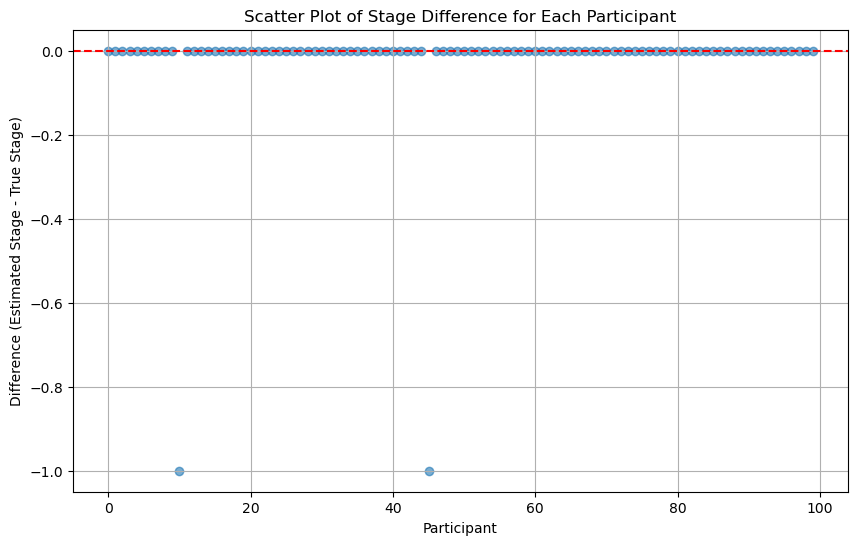

In [9]:
scatter_plot_of_stage_differences(differences)


In [10]:
data_we_have = data.drop(['k_j', 'affected_or_not'], axis = 1)
data_we_have.head()

,Biomarker,participant,measurement,S_n
0,0,0,10.336151,5
1,0,1,10.865467,5
2,0,2,1.238857,5
3,0,3,10.163485,5
4,0,4,11.036735,5


In [11]:
def fill_up_data_we_have(data_we_have, participant_stages):
    '''This is to fill up data_we_have. 
    Basically, add two columns: k_j, and affected, based on initial or updated participant_stages

    Essentially, all we do below is to get the most accurate participant_stages
    '''
    participant_stage_dic = dict(zip(np.arange(0,len(participants)), participant_stages))
    data_we_have['k_j'] = data_we_have.apply(lambda row: participant_stage_dic[row.participant], axis = 1)
    data_we_have['affected'] = data_we_have.apply(lambda row: row.k_j >= row.S_n, axis = 1)
    return data_we_have 

In [12]:
def estimate_params_exact(m0, n0, s0_sq, v0, data):
    '''
    data: a vector of measurements. It is of a specific biomarker and of a specific type (affected, or not affected)
    '''
    # Data summary
    sample_mean = np.mean(data)
    sample_size = len(data)
    sample_var = np.var(data, ddof=1)  # ddof=1 for unbiased estimator

    # Update hyperparameters for the Normal-Inverse Gamma posterior
    updated_m0 = (n0 * m0 + sample_size * sample_mean) / (n0 + sample_size)
    updated_n0 = n0 + sample_size
    updated_v0 = v0 + sample_size 
    updated_s0_sq = (1 / updated_v0) * ((sample_size - 1) * sample_var + v0 * s0_sq + 
                    (n0 * sample_size / updated_n0) * (sample_mean - m0)**2)
    updated_alpha = updated_v0/2
    updated_beta = updated_v0*updated_s0_sq/2

    # Posterior estimates
    mu_posterior_mean = updated_m0
    sigma_squared_posterior_mean = updated_beta/updated_alpha

    return mu_posterior_mean, sigma_squared_posterior_mean

In [13]:
def get_estimated_means_vars_df(biomarkers, data_we_have):
    '''To get estimated parameters, returns a Pandas DataFrame
    Input:
    - biomarkers: 0-9
    - data_we_have: participants data filled with initial or updated participant_stages

    Output: 
    - estimate_means_vars_df, just like means_vars_df, containing the estimated mean and var for 
      distribution of biomarker values when the biomarker is affected and not affected

    Special note: 
    '''
    # empty list of dictionaries to store the estimates 
    means_vars_estimate_dict_list = []
    for biomarker in biomarkers: 
        dic = {'biomarker': biomarker}  # Initialize dictionary outside the inner loop
        for affected in [True, False]:
            data_full = data_we_have[(data_we_have.Biomarker == str(biomarker)) & (
            data_we_have.affected == affected)]
            data = np.array(data_full.measurement)
            # if len(data) == 0:
            #     print(data_full)
            mu_estimate, var_estimate = estimate_params_exact(
                m0 = 0, n0 = 1, s0_sq = 1, v0 = 1, data=data)
            if affected:
                dic['theta_mean'] = mu_estimate
                dic['theta_var'] = var_estimate
            else:
                dic['phi_mean'] = mu_estimate
                dic['phi_var'] = var_estimate
        means_vars_estimate_dict_list.append(dic)
    estimate_means_vars_df = pd.DataFrame(means_vars_estimate_dict_list)
    return estimate_means_vars_df 

In [14]:
biomarkers = np.arange(start = 0, stop = 10, step = 1)
participants = data.participant.unique()
num_iterations = 3
num_stages = len(data_we_have.S_n.unique())
# initialize participant_stages 
# note that high should be num_stages + 1; otherwise, no participants will be in the stage of 10
participant_stages = np.random.randint(low = 0, high = num_stages+1, size = len(participants))

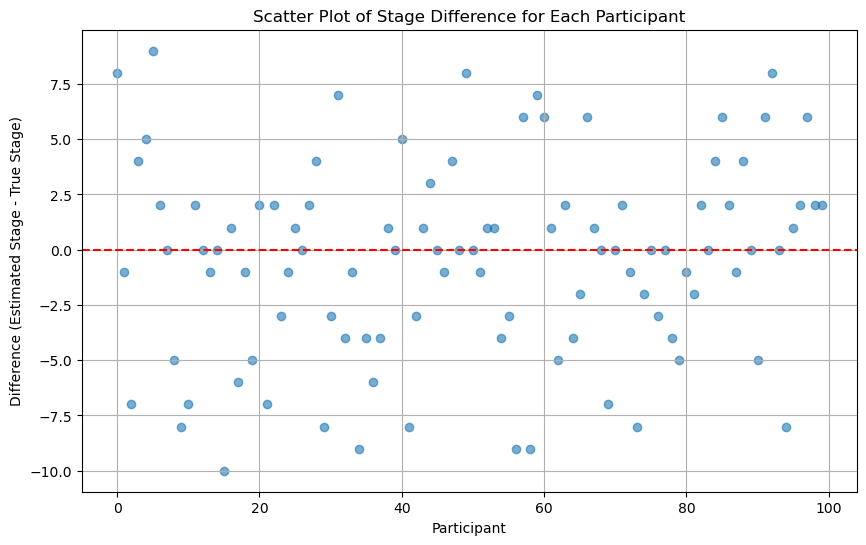

In [15]:
estimated_stages = participant_stages
actual_stages = np.array(list(actual_stage_dic.values()))
differences = estimated_stages - actual_stages

scatter_plot_of_stage_differences(differences)

In [16]:
# import warnings
# warnings.filterwarnings('ignore')

for i in range(num_iterations):
    # fill up data_we_have with the current participant_stages
    data_we_have = fill_up_data_we_have(data_we_have, participant_stages)
    estimated_means_vars_df = get_estimated_means_vars_df(biomarkers, data_we_have)
    for p in participants:
        p_data = data_we_have[data_we_have.participant == p].reset_index(drop=True)
        stage_likelihood = np.zeros(num_stages + 1)
        # note that it should be [0, 10]
        for k in range(num_stages + 1):
            likelihood = 1
            for biomarker in biomarkers:
                # biomarker data for this participant
                p_biomaker_data = p_data[
                    p_data.Biomarker == str(biomarker)
                ].reset_index(drop=True)
                measurement = p_biomaker_data.measurement[0]
                biomarker_stage = p_biomaker_data.S_n[0]
                affected = k >= biomarker_stage

                # the final updated likelihood is the likelihood of seeing 
                # this sequence of data of the total number of biomarkers
                # This is using the equation here: https://ebm-book2.vercel.app/distributions.html#known-k-j
                likelihood *= compute_likelihood(
                    estimated_means_vars_df, biomarker, affected, measurement
                )
                # if the participant is in this stage, what is the likelihood of seeing this 
                # sequence of values
                stage_likelihood[k] = likelihood
        max_likelihood_stage = pd.Series(stage_likelihood).idxmax()
        # update participant_stages
        participant_stages[p] = max_likelihood_stage  
    print(f"iteration {i} done")

iteration 0 done


iteration 1 done


iteration 2 done


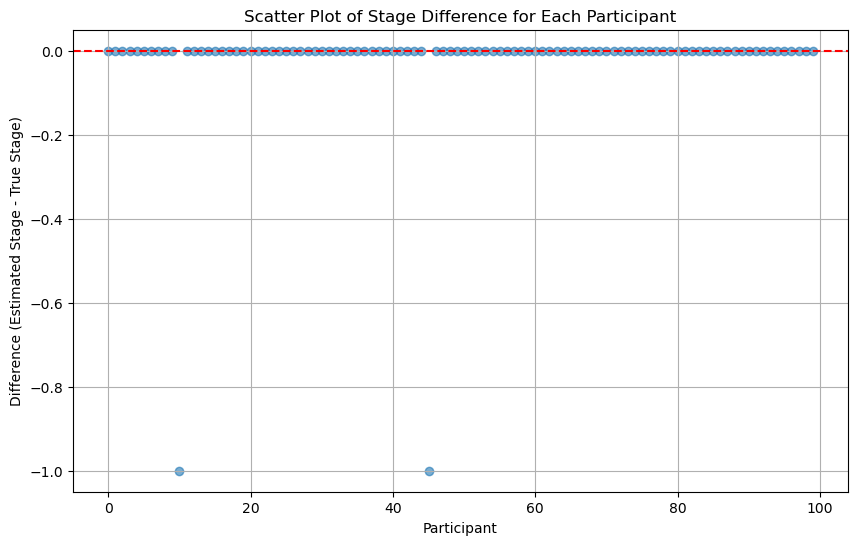

In [17]:
estimated_stages = participant_stages
actual_stages = np.array(list(actual_stage_dic.values()))
differences = estimated_stages - actual_stages
scatter_plot_of_stage_differences(differences)